# Cluster DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6 IT Car3" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6b" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [86]:
isoform = anndata.read_h5ad("../cell_ranger_annotation/isoform.h5ad")
gene =    anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [87]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

In [82]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate")
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [88]:
gene = gene[gene.obs.subclass_label=="L5 IT"]
isoform = isoform[isoform.obs.subclass_label=="L5 IT"]

In [89]:
%%time
mat           = gene.layers["log1p"]
components    = gene.obs.cell_id.values
gene_features = gene.var.gene_name.values
assignments   = gene.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.80 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw, corr_method)
s_gene = stat

28-Feb-20 17:58:12 - 1 of 7 assignments: L5 IT Pld5
28-Feb-20 17:58:12 - 2 of 7 assignments: L5 IT Rspo1
28-Feb-20 17:58:12 - 3 of 7 assignments: L5 IT Rspo2
28-Feb-20 17:58:12 - 4 of 7 assignments: L5 IT S100b_1
28-Feb-20 17:58:12 - 5 of 7 assignments: L5 IT S100b_2
28-Feb-20 17:58:12 - 6 of 7 assignments: L5 IT Tcap_1
28-Feb-20 17:58:13 - 7 of 7 assignments: L5 IT Tcap_2


CPU times: user 698 ms, sys: 305 ms, total: 1 s
Wall time: 998 ms


In [90]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.80 # of elements in cluster
corr_method = "bonferroni"


p_isoform_raw, stat = dexpress(mat, components, features, assignments, 
                      nan_cutoff=nan_cutoff)

p_isoform = correct_pval(p_isoform_raw/2, corr_method)
s_isoform = stat

28-Feb-20 17:58:14 - 1 of 7 assignments: L5 IT Pld5
28-Feb-20 17:58:15 - 2 of 7 assignments: L5 IT Rspo1
28-Feb-20 17:58:15 - 3 of 7 assignments: L5 IT Rspo2
28-Feb-20 17:58:15 - 4 of 7 assignments: L5 IT S100b_1
28-Feb-20 17:58:16 - 5 of 7 assignments: L5 IT S100b_2
28-Feb-20 17:58:16 - 6 of 7 assignments: L5 IT Tcap_1
28-Feb-20 17:58:17 - 7 of 7 assignments: L5 IT Tcap_2


CPU times: user 1.76 s, sys: 1.26 s, total: 3.02 s
Wall time: 3.02 s


In [91]:
# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [92]:
repeat_col = gene.var["num_isoforms"]

p1 = p_isoform
p2 = np.repeat(p_gene, repeat_col, axis=1)

s1 = s_isoform
s2 = np.repeat(s_gene, repeat_col, axis=1)

In [93]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

p2_mask = np.logical_or(np.logical_and(p2>alpha, s2>tcrit), np.logical_and(p2<alpha, s2<tcrit))

mask = np.logical_and(p1_mask, p2_mask)
bool_mask = mask

In [94]:
bool_mask.sum()

799

In [95]:
unique

array(['L5 IT Pld5', 'L5 IT Rspo1', 'L5 IT Rspo2', 'L5 IT S100b_1',
       'L5 IT S100b_2', 'L5 IT Tcap_1', 'L5 IT Tcap_2'], dtype=object)

In [96]:
markers_gene = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])
markers_isoform = pd.DataFrame(index=unique, columns=["transcript_name", "p_raw", "p_bonferroni"])

In [97]:
unique = gene.obs.cluster_label.unique()

In [98]:
isoform_features = isoform.var.transcript_name.values

for uidx, u in enumerate(unique):
    mask = np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_isoform[uidx][mask]
    p_raw = p_isoform_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_isoform.loc[u]["transcript_name"] = fsorted
    markers_isoform.loc[u]["p_raw"] = p_raw_sorted
    markers_isoform.loc[u]["p_bonferroni"] = psorted

In [99]:
markers_isoform

,transcript_name,p_raw,p_bonferroni
L5 IT Pld5,"[Cntfr-201, Fbxl2-206, Fam49b-204, Tmem196-203...","[4.2868183098001106e-09, 1.1997334853420963e-0...","[0.00018082656994398825, 0.005060715787870031,..."
L5 IT Rspo1,"[Rbfox1-208, Thg1l-202, Zfp207-204, Eif4e-204,...","[3.97504708863603e-26, 1.1332118805259645e-18,...","[1.6767543629284502e-21, 4.7801143544346234e-1..."
L5 IT Rspo2,"[Strbp-201, Clip1-206, Hmgn3-201]","[3.2713153272312357e-09, 3.2362205172594317e-0...","[0.000137990623133268, 0.0013651025385903735, ..."
L5 IT S100b_1,"[Bend5-201, Dmxl2-201, Ino80e-203, Ncoa7-201, ...","[4.509052119742233e-27, 7.586868072044631e-19,...","[1.9020083651496688e-22, 3.200292690149866e-14..."
L5 IT S100b_2,"[Rcan2-201, Cbln2-201, Igfbp4-203, Cbln2-204, ...","[7.705576081319433e-23, 2.1290021152809787e-08...","[3.250366102622163e-18, 0.0008980556722678224,..."
L5 IT Tcap_1,"[Slbp-206, Erc2-207, Fbxo7-204, Far1-201, Cops...","[1.4295275419356299e-16, 7.737915427352037e-16...","[6.030033077392874e-12, 3.2640074855656364e-11..."
L5 IT Tcap_2,"[Gm38134-201, Lrrtm1-202, Trpc4ap-205, Ywhaz-2...","[1.6207316198926084e-46, 2.7695775555458627e-3...","[6.836570119031001e-42, 1.1682632044803558e-28..."


In [37]:
isoform.obs.cluster_label.value_counts()

L2/3 IT S100a6       231
L2/3 IT Macc1        128
L2/3 IT Cdh13 Sla    123
Name: cluster_label, dtype: int64

In [100]:
markers_isoform.loc['L5 IT Pld5']["transcript_name"]

array(['Cntfr-201', 'Fbxl2-206', 'Fam49b-204', 'Tmem196-203', 'Cdc42-201',
       'Chmp2a-203'], dtype=object)

In [105]:
specific_cluster = "L5 IT Pld5"
specific_isoform = "Fam49b-204"
specific_gene = "".join(specific_isoform.split("-")[:-1])

28-Feb-20 17:59:14 - update_title_pos
28-Feb-20 17:59:14 - update_title_pos
28-Feb-20 17:59:15 - update_title_pos
28-Feb-20 17:59:15 - update_title_pos
28-Feb-20 17:59:15 - update_title_pos
28-Feb-20 17:59:15 - update_title_pos
28-Feb-20 17:59:15 - update_title_pos
28-Feb-20 17:59:15 - update_title_pos


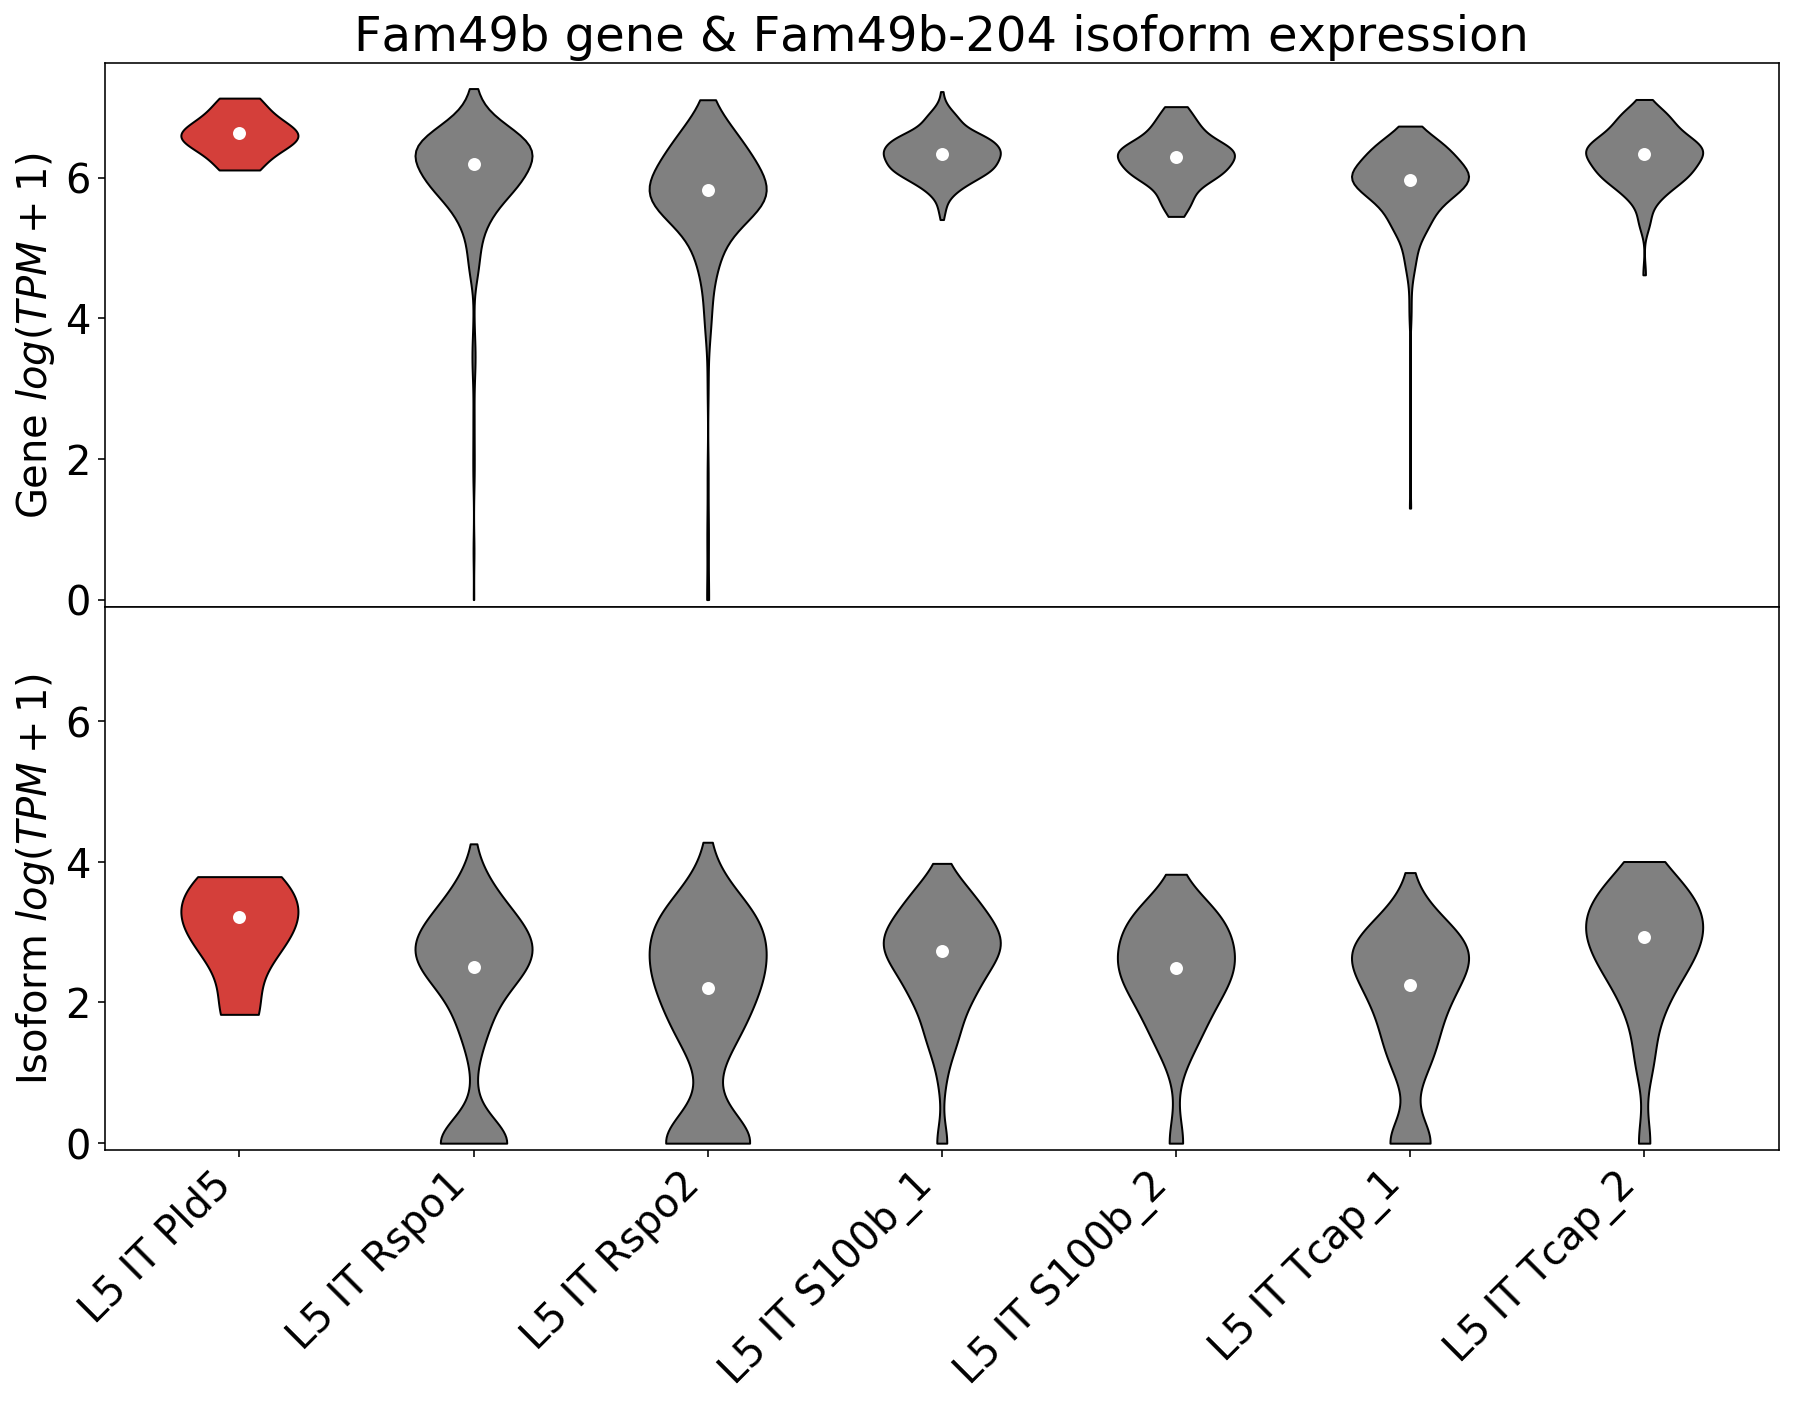

In [106]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.cluster_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1).tolist())

parts = ax[0].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax[0].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k")
ax[0].set_ylabel("Gene $log(TPM + 1)$")

######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.cluster_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax[1].violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

ax[0].set_ylim(-0.1)
medians = [np.median(i) for i in x]
ax[1].scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax[1].set_xticks(lidx)
ax[1].set_xticklabels(labels, rotation=45, ha="right")
ax[1].set_ylabel("Isoform $log(TPM + 1)$")
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim((ymin, ymax))
ax[0].set_title("{} gene & {} isoform expression".format(specific_gene, specific_isoform))
#plt.savefig("./level_2_fig/hidden_gene_violin_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()

28-Feb-20 18:00:21 - update_title_pos
28-Feb-20 18:00:21 - update_title_pos
28-Feb-20 18:00:21 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos
28-Feb-20 18:00:22 - update_title_pos


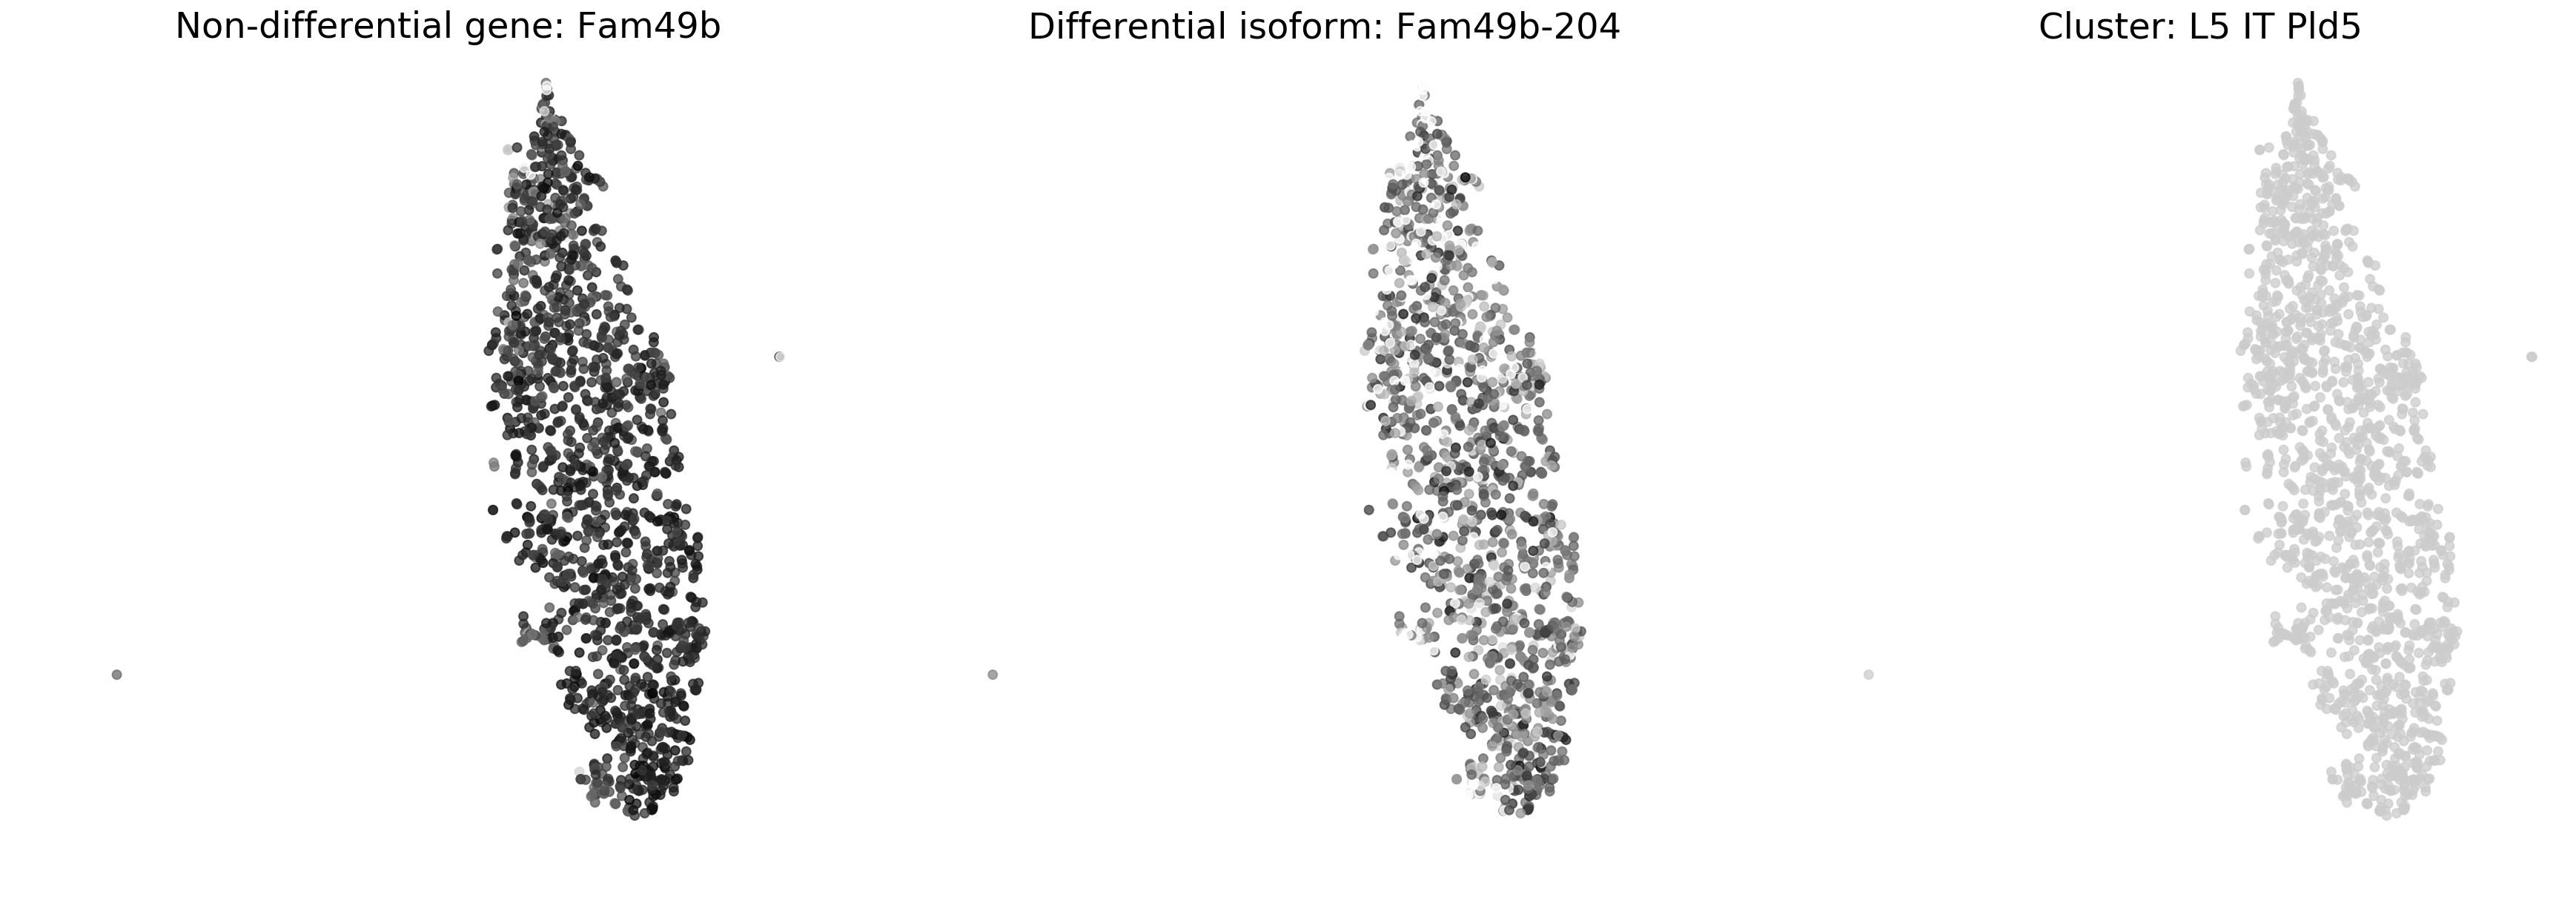

In [108]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"]).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["cluster_label"]==specific_cluster
#c = gene.obs["cluster_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["cluster_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
#plt.savefig("./level_2_fig/hidden_gene_nca_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()